In [5]:
using Pkg
Pkg.activate("../Project.toml")

include("../LogLoss/RealRealHighDimension.jl")
using JLD2
using DataFrames


  Activating project at `~/Documents/QuantumInspiredML/QuantumInspiredML`


In [125]:
function buildf0(x,sigma,x0)
    f0 = @. exp( -(x -0.5)^2/2/sigma^2)# np.exp(-(x-x0)**2/2/sigma**2) + 2*np.exp(-(x-0.5)**2/2/0.7**2) + np.exp(-(x+0.6)**2/2/0.8**2) 
    dx = x[2]-x[1]
    return f0/sqrt(sum(f0.^2)*dx)
end

function buildfn(x,f0,n,cVecs)
    func = zeros(size(x))
    for i in 1:n
        func += cVecs[n,i] .* (x .^(i-1)).*f0
    end
        
    return func
end

buildfn (generic function with 1 method)

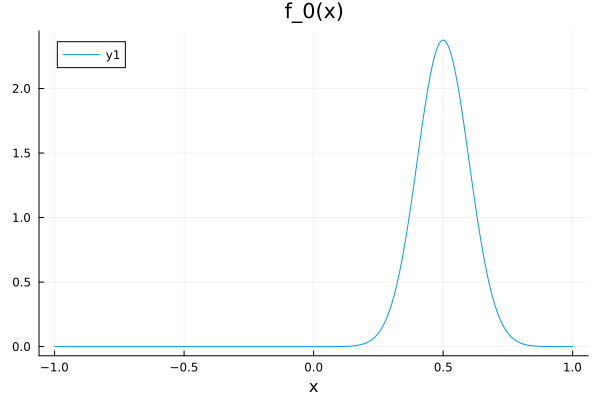

In [51]:
x = range(-1,1,501)
dx=x[2]-x[1]
sigma=0.1
x0=0.1

f0 = buildf0(x,sigma,x0)

plot(x, f0, xlabel="x", title="f_0(x)" )




In [48]:
sum(f0.^2)*dx  #check normalisation

1.0

In [97]:
function construct_sahand_legendre_basis(xs_samp::AbstractVector{<:Real}, f0::AbstractVector{<:Real}, d::Integer)
    # dx=x[1]-x[0]
    N=d-1
    cVecs = zeros(N+1,N+1) # rows are the n (order of f) and columns are the i (order of the polynomial in the sum to make f)
    cVecs[1,1] = 1 #c_00 is always 1

    #Build the matrix of overlaps. (This is really only a vector, but it's convenient to build it as a matrix like this)
    Mij = zeros(N+1,N+1)
    for i in 0:N, j in 0:N
        problem = SampledIntegralProblem((@. xs_samp^(i+j) * f0^2, x)...)
        s = solve(problem, TrapezoidalRule())
        Mij[i+1,j+1] = s.u
    end

    #now we iterate and get the functions
    for n in 1:N
        if n == 1
            #special case of getting the f1 function from the f0 function
            cVecs[2,1]=1 #set the first c value to 1
            cVecs[2,2] = -1/Mij[2,1] #get the second c value
            norm =  transpose(cVecs[2, 1:2]) * Mij[1:2,1:2] * cVecs[2,1:2]
            # norm = np.einsum("ij,i,j",Mij[0:2,0:2],cVecs[1,0:2],cVecs[1,0:2]) #normalise the function in terms of its c values
            cVecs[2,:] = cVecs[2,:]/sqrt(norm) # renormalise the c values
            
        else
            deltaVecTemp = zeros(n) # build the vector representing the kronecker delta on LHS of notes
            MijTemp = Mij[1,1:n] # get M_0j
            cVecTemp = cVecs[1:n,1:n] * MijTemp
            # cVecTemp = np.einsum("mj,j->m",cVecs[0:n+1,0:n+1],MijTemp) # get c_mj
        
            # Now build Mij cmj on RHS, which is the matrix we want to invert
            MijTemp = Mij[2:n+1,1:n]
            Aij = cVecs[1:n, 1:n] * transpose(MijTemp)
            # Aij = np.einsum("mj,ij->mi",cVecs[0:n+1,0:n+1],MijTemp)
        
            #now solve the problem
            inhomo = deltaVecTemp - cVecTemp #the inhomogeneous term
            cVecSol = Aij \ inhomo
            # cVecSol = np.linalg.solve(Aij, inhomo) #solve the linear problem
            cVecs[n+1,1] = 1 #set c_0 to 1
            for i in 2:n+1
                cVecs[n+1,i] = cVecSol[i-1] #use solutions to define new entries
            end
            norm = transpose(cVecs[n+1, 1:n+1]) * Mij[1:n+1, 1:n+1] * cVecs[n+1, 1:n+1]
            # norm = np.einsum("ij,i,j",Mij[0:n+2,0:n+2],cVecs[n+1,0:n+2],cVecs[n+1,0:n+2]) #Normalise the new basisfunction
            cVecs[n+1,:] = cVecs[n+1,:]/sqrt(norm) #renormalise the new basis function using the new cvecs
        end
    end
    return cVecs
end

construct_sahand_legendre_basis (generic function with 1 method)

In [133]:
d = 6
cVecs = construct_sahand_legendre_basis(x, f0, d)

6×6 Matrix{Float64}:
    1.0           0.0         0.0         0.0           0.0           0.0
    7.07107     -14.1421      0.0         0.0           0.0           0.0
   34.6482     -141.421     141.421       0.0           0.0           0.0
  135.677      -848.705    1732.05    -1154.7           0.0           0.0
  449.686     -3837.53    12002.5    -16329.9        8164.97          0.0
 1300.68     -14220.3     60676.8        -1.26518e5     1.291e5  -51639.8

In [134]:
f1 = buildfn(x,f0,2,cVecs)
f2 = buildfn(x,f0,3,cVecs)
f3 = buildfn(x,f0,4,cVecs);
f4 = buildfn(x,f0,5,cVecs)
f5 = buildfn(x,f0,6,cVecs);


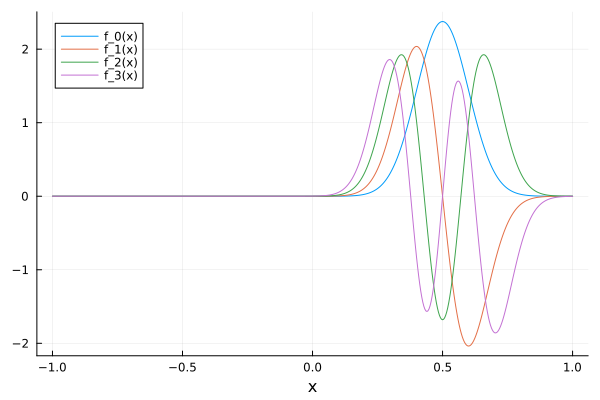

In [129]:
plot(x,f0, label="f_0(x)")
plot!(x,f1, label="f_1(x)")
plot!(x,f2, label="f_2(x)")
plot!(x,f3, label="f_3(x)")
#plt.plot(x,f4)
#plt.plot(x,f5)
xlabel!("x",fontsize=16)



In [137]:
println(sum(f1.*f2)*dx)
println(sum(f1.*f3)*dx)
println(sum(f1.*f4)*dx)
println(sum(f1.*f5)*dx)

println(sum(f2.*f3)*dx)
println(sum(f2.*f4)*dx)
println(sum(f2.*f5)*dx)

println(sum(f3.*f4)*dx)
println(sum(f3.*f5)*dx)

println(sum(f4.*f5)*dx)


-3.732007624618619e-11
1.5780111155075886e-10
-4.617490454477309e-10
1.577728031140724e-9
-6.900948232777327e-10
2.6390473654259823e-9
-6.4480888924212325e-9
-8.833479248509546e-9
2.7535636987578635e-8
-1.2956907101078517e-7


In [138]:
println(sum(f1.*f1)*dx)
println(sum(f2.*f2)*dx)
println(sum(f3.*f3)*dx)
println(sum(f4.*f4)*dx)
println(sum(f5.*f5)*dx)

1.0000000000078975
1.0000000001966398
1.0000000031055631
1.0000000343876714
0.999999867242876
